In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.autograd import Variable 
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
#model_weights = torch.utils.model_zoo.load_url("https://download.pytorch.org/models/alexnet-owt-4df8aa71.pth")
#converter.get_model(model_weights)

In [4]:
SEED = 1                              #Seed the random wieghts on initialization
LOG_INTERVAL = 100                    #How often to log training and testing info
#Dataloader
#@title Batch Hyper Parameters
BATCH_SIZE = 64           #@param {type:"integer"}  #Number of training images to process before updating weights
TEST_BATCH_SIZE = 1000    #@param {type:"number"}   #Number of test images to process at once
kwargs = {'num_workers': 1, 'pin_memory': True}
train_loader  = torch.utils.data.DataLoader(
    datasets.MNIST('/tmp/mnist/data', 
                   train=True, 
                   download=True, 
                   transform=transforms.Compose([
                                transforms.ToTensor(),
                                transforms.Normalize((0.1307,),
                                                     (0.3081,))
                              ])),
    batch_size=BATCH_SIZE,
    shuffle=True,
    **kwargs)

test_loader = torch.utils.data.DataLoader(
    datasets.MNIST('/tmp/mnist/data', 
                   train=False, 
                   transform=transforms.Compose([
                                transforms.ToTensor(),
                                transforms.Normalize((0.1307,),
                                                     (0.3081,))
                                ])),
    batch_size=TEST_BATCH_SIZE,
    shuffle=True,
    **kwargs
)


def train(model, optimizer, loss_func, epoch, training_history):
    model.train()                                            #Set training mode 
    for batch, (data, target) in enumerate(train_loader):
        data, target = Variable(data), Variable(target)      #Make data and correct answers variables in the Network
        optimizer.zero_grad()                                #zero the gradients
        output = model(data)                                 #classify the data
        loss = loss_func(output, target)                     #calculate the loss
        loss.backward()                                      #propogate the weight updates through the network
        optimizer.step()
        if batch % LOG_INTERVAL == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(epoch, batch * len(data), len(train_loader.dataset), 100. * batch / len(train_loader), loss.data[0]))
            training_history.append(((len(train_loader.dataset) * epoch) + batch * len(data), loss.data[0]))


def test(model, loss_func, epoch, test_loss_history, test_accuracy_history):
    model.eval()
    test_loss = 0
    correct = 0
    for data, target in test_loader:
        data, target = Variable(data, volatile=True), Variable(target) #Make data and correct answers variables in the Network
        output = model(data)                                           #classify the data
        test_loss += loss_func(output, target).data[0]                 #calculate loss
        pred = output.data.max(1)[1]                                   #get predictions for the batch using argmax
        correct += pred.eq(target.data).cpu().sum()                    #total correct anwsers 
    test_loss /= len(test_loader)
    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(test_loss, correct, len(test_loader.dataset), 100. * correct / len(test_loader.dataset)))
    test_loss_history.append((epoch, test_loss))
    test_accuracy_history.append((epoch, 100. * correct / len(test_loader.dataset)))
    
def learn(model, optimizer, loss_func):
    training_loss = []
    test_loss = []
    test_accuracy = []
    for e in range(EPOCHS):
        train(model, optimizer, loss_func, e + 1, training_loss)
        test(model, loss_func, e + 1, test_loss, test_accuracy)
    return (training_loss, test_loss, test_accuracy)



def visualize_learning(training_loss, test_loss, test_accuracy):
    f1 = plt.figure()
    f2 = plt.figure()
    f3 = plt.figure()
    ax1 = f1.add_subplot(111)
    ax2 = f2.add_subplot(111)
    ax3 = f3.add_subplot(111)

    training_loss_batch, training_loss_values = zip(*training_loss)
    ax1.plot(training_loss_batch, training_loss_values)
    ax1.set_title('Training Loss')
    ax1.set_xlabel("Batch")
    ax1.set_ylabel("Loss")


    test_loss_epoch, test_loss_values = zip(*test_loss)
    ax2.plot(test_loss_epoch, test_loss_values)
    ax2.set_title("Testing Loss")
    ax2.set_xlabel("Batch")
    ax2.set_ylabel("Loss")

    test_accuracy_epoch, test_accuracy_values = zip(*test_accuracy)
    ax3.plot(test_accuracy_epoch, test_accuracy_values)
    ax3.set_title("Testing Accuracy")
    ax3.set_xlabel("Batch")
    ax3.set_ylabel("Accuracy (%)")

    plt.show()

def classify(model, img):
    img = Variable(img, volatile=True)
    output = model(img)
    return output.data.max(1)[1]

def classify_an_example(model):
    img = next(iter(test_loader))[0]
    img_np = img.numpy()[0]
    plt.imshow(img_np.reshape(28,28))
    print()
    print("The image is probably: {}".format(classify(model, img)[0]))
    print()

Processing
Done!


In [5]:
#train MLP
class NarrowMLP(nn.Module):
    '''
    3 Hidden Layers, Aggressive Narrowing of Model Width
    '''
    def __init__(self):
        super(NarrowMLP, self).__init__()
        self.fc1 = nn.Linear(784, 400)
        self.fc2 = nn.Linear(400, 200)
        self.fc3 = nn.Linear(200, 100)
        self.fc4 = nn.Linear(100, 50)
        self.fc5 = nn.Linear(50,10)
    def forward(self, x):
        x = x.view(-1, 784)
        x = F.relu(self.fc1(x)) 
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        x = F.relu(self.fc4(x))
        x = F.relu(self.fc5(x))
        return F.log_softmax(x, dim=1)

In [6]:
#train MLP
class ConstantMLP(nn.Module):
    '''
    3 Hidden Layers, Constant Model Width for the Hidden Layers
    '''
    def __init__(self):
        super(ConstantMLP, self).__init__()
        self.fc1 = nn.Linear(784, 400)
        self.fc2 = nn.Linear(400, 400)
        self.fc3 = nn.Linear(400, 400)
        self.fc4 = nn.Linear(400, 400)
        self.fc5 = nn.Linear(400,10)
    def forward(self, x):
        x = x.view(-1, 784)
        x = F.relu(self.fc1(x)) 
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        x = F.relu(self.fc4(x))
        x = F.relu(self.fc5(x))
        return F.log_softmax(x, dim=1)

In [7]:
#train MLP
class WiderMLP(nn.Module):
    '''
    3 Hidden Layers, Model Gets progressively wider
    '''
    def __init__(self):
        super(WiderMLP, self).__init__()
        self.fc1 = nn.Linear(784, 400)
        self.fc2 = nn.Linear(400, 800)
        self.fc3 = nn.Linear(800, 1600)
        self.fc4 = nn.Linear(1600, 3200)
        self.fc5 = nn.Linear(3200,10)
    def forward(self, x):
        x = x.view(-1, 784)
        x = F.relu(self.fc1(x)) 
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        x = F.relu(self.fc4(x))
        x = F.relu(self.fc5(x))
        return F.log_softmax(x, dim=1)

In [8]:
#@title Training Hyper Parameters
EPOCHS = 15                #@param {type:"integer"}           #Number of times to go through the data set
SGD_MOMENTUM = 0.5        #@param {type:"number"}            #How much it takes to change the direction of the gradient
LEARNING_RATE = 0.001     #@param {type:"number"}            #How far each update pushes the weights
narrow_mlp_model = NarrowMLP()
mlp_optimizer = optim.SGD(narrow_mlp_model.parameters(), lr=LEARNING_RATE, momentum=SGD_MOMENTUM)
print(narrow_mlp_model)
NMLP_TRAINING_LOSS, NMLP_TEST_LOSS, NMLP_TEST_ACCURACY = learn(narrow_mlp_model, mlp_optimizer, F.nll_loss)

NarrowMLP(
  (fc1): Linear(in_features=784, out_features=400, bias=True)
  (fc2): Linear(in_features=400, out_features=200, bias=True)
  (fc3): Linear(in_features=200, out_features=100, bias=True)
  (fc4): Linear(in_features=100, out_features=50, bias=True)
  (fc5): Linear(in_features=50, out_features=10, bias=True)
)
Train Epoch: 1 [0/60000 (0%)]	Loss: 2.303554


/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:45: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:46: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Train Epoch: 1 [6400/60000 (11%)]	Loss: 2.297291
Train Epoch: 1 [12800/60000 (21%)]	Loss: 2.297070
Train Epoch: 1 [19200/60000 (32%)]	Loss: 2.298538
Train Epoch: 1 [25600/60000 (43%)]	Loss: 2.298860
Train Epoch: 1 [32000/60000 (53%)]	Loss: 2.309332
Train Epoch: 1 [38400/60000 (64%)]	Loss: 2.296344
Train Epoch: 1 [44800/60000 (75%)]	Loss: 2.303289
Train Epoch: 1 [51200/60000 (85%)]	Loss: 2.293861
Train Epoch: 1 [57600/60000 (96%)]	Loss: 2.286557


/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:54: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:56: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number



Test set: Average loss: 2.2963, Accuracy: 1763/10000 (17%)

Train Epoch: 2 [0/60000 (0%)]	Loss: 2.304132
Train Epoch: 2 [6400/60000 (11%)]	Loss: 2.301384
Train Epoch: 2 [12800/60000 (21%)]	Loss: 2.281378
Train Epoch: 2 [19200/60000 (32%)]	Loss: 2.292085
Train Epoch: 2 [25600/60000 (43%)]	Loss: 2.277106
Train Epoch: 2 [32000/60000 (53%)]	Loss: 2.288744
Train Epoch: 2 [38400/60000 (64%)]	Loss: 2.292536
Train Epoch: 2 [44800/60000 (75%)]	Loss: 2.292166
Train Epoch: 2 [51200/60000 (85%)]	Loss: 2.294347
Train Epoch: 2 [57600/60000 (96%)]	Loss: 2.289543

Test set: Average loss: 2.2851, Accuracy: 2339/10000 (23%)

Train Epoch: 3 [0/60000 (0%)]	Loss: 2.280377
Train Epoch: 3 [6400/60000 (11%)]	Loss: 2.278211
Train Epoch: 3 [12800/60000 (21%)]	Loss: 2.281600
Train Epoch: 3 [19200/60000 (32%)]	Loss: 2.282900
Train Epoch: 3 [25600/60000 (43%)]	Loss: 2.273894
Train Epoch: 3 [32000/60000 (53%)]	Loss: 2.265572
Train Epoch: 3 [38400/60000 (64%)]	Loss: 2.270651
Train Epoch: 3 [44800/60000 (75%)]	Loss:

In [9]:
constant_mlp_model = ConstantMLP()
mlp_optimizer = optim.SGD(constant_mlp_model.parameters(), lr=LEARNING_RATE, momentum=SGD_MOMENTUM)
print(constant_mlp_model)
CMLP_TRAINING_LOSS, CMLP_TEST_LOSS, CMLP_TEST_ACCURACY = learn(constant_mlp_model, mlp_optimizer, F.nll_loss)

ConstantMLP(
  (fc1): Linear(in_features=784, out_features=400, bias=True)
  (fc2): Linear(in_features=400, out_features=400, bias=True)
  (fc3): Linear(in_features=400, out_features=400, bias=True)
  (fc4): Linear(in_features=400, out_features=400, bias=True)
  (fc5): Linear(in_features=400, out_features=10, bias=True)
)
Train Epoch: 1 [0/60000 (0%)]	Loss: 2.300664


/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:45: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:46: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Train Epoch: 1 [6400/60000 (11%)]	Loss: 2.302294
Train Epoch: 1 [12800/60000 (21%)]	Loss: 2.298786
Train Epoch: 1 [19200/60000 (32%)]	Loss: 2.292031
Train Epoch: 1 [25600/60000 (43%)]	Loss: 2.303147
Train Epoch: 1 [32000/60000 (53%)]	Loss: 2.298704
Train Epoch: 1 [38400/60000 (64%)]	Loss: 2.300585
Train Epoch: 1 [44800/60000 (75%)]	Loss: 2.293214
Train Epoch: 1 [51200/60000 (85%)]	Loss: 2.285655
Train Epoch: 1 [57600/60000 (96%)]	Loss: 2.289277


/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:54: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:56: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number



Test set: Average loss: 2.2886, Accuracy: 2607/10000 (26%)

Train Epoch: 2 [0/60000 (0%)]	Loss: 2.279180
Train Epoch: 2 [6400/60000 (11%)]	Loss: 2.288130
Train Epoch: 2 [12800/60000 (21%)]	Loss: 2.283424
Train Epoch: 2 [19200/60000 (32%)]	Loss: 2.285532
Train Epoch: 2 [25600/60000 (43%)]	Loss: 2.281109
Train Epoch: 2 [32000/60000 (53%)]	Loss: 2.283721
Train Epoch: 2 [38400/60000 (64%)]	Loss: 2.282114
Train Epoch: 2 [44800/60000 (75%)]	Loss: 2.279808
Train Epoch: 2 [51200/60000 (85%)]	Loss: 2.276313
Train Epoch: 2 [57600/60000 (96%)]	Loss: 2.275653

Test set: Average loss: 2.2615, Accuracy: 4302/10000 (43%)

Train Epoch: 3 [0/60000 (0%)]	Loss: 2.266177
Train Epoch: 3 [6400/60000 (11%)]	Loss: 2.252588
Train Epoch: 3 [12800/60000 (21%)]	Loss: 2.249701
Train Epoch: 3 [19200/60000 (32%)]	Loss: 2.250337
Train Epoch: 3 [25600/60000 (43%)]	Loss: 2.258027
Train Epoch: 3 [32000/60000 (53%)]	Loss: 2.212448
Train Epoch: 3 [38400/60000 (64%)]	Loss: 2.202396
Train Epoch: 3 [44800/60000 (75%)]	Loss:

In [10]:
wider_mlp_model = WiderMLP()
mlp_optimizer = optim.SGD(wider_mlp_model.parameters(), lr=LEARNING_RATE, momentum=SGD_MOMENTUM)
print(constant_mlp_model)
WMLP_TRAINING_LOSS, WMLP_TEST_LOSS, WMLP_TEST_ACCURACY = learn(wider_mlp_model, mlp_optimizer, F.nll_loss)

ConstantMLP(
  (fc1): Linear(in_features=784, out_features=400, bias=True)
  (fc2): Linear(in_features=400, out_features=400, bias=True)
  (fc3): Linear(in_features=400, out_features=400, bias=True)
  (fc4): Linear(in_features=400, out_features=400, bias=True)
  (fc5): Linear(in_features=400, out_features=10, bias=True)
)
Train Epoch: 1 [0/60000 (0%)]	Loss: 2.301148


/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:45: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:46: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Train Epoch: 1 [6400/60000 (11%)]	Loss: 2.293452
Train Epoch: 1 [12800/60000 (21%)]	Loss: 2.297200
Train Epoch: 1 [19200/60000 (32%)]	Loss: 2.297227
Train Epoch: 1 [25600/60000 (43%)]	Loss: 2.291692
Train Epoch: 1 [32000/60000 (53%)]	Loss: 2.287397
Train Epoch: 1 [38400/60000 (64%)]	Loss: 2.290106
Train Epoch: 1 [44800/60000 (75%)]	Loss: 2.286295
Train Epoch: 1 [51200/60000 (85%)]	Loss: 2.278241
Train Epoch: 1 [57600/60000 (96%)]	Loss: 2.274600


/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:54: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:56: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number



Test set: Average loss: 2.2734, Accuracy: 3991/10000 (39%)

Train Epoch: 2 [0/60000 (0%)]	Loss: 2.270042
Train Epoch: 2 [6400/60000 (11%)]	Loss: 2.274367
Train Epoch: 2 [12800/60000 (21%)]	Loss: 2.269634
Train Epoch: 2 [19200/60000 (32%)]	Loss: 2.257901
Train Epoch: 2 [25600/60000 (43%)]	Loss: 2.249006
Train Epoch: 2 [32000/60000 (53%)]	Loss: 2.237917
Train Epoch: 2 [38400/60000 (64%)]	Loss: 2.227039
Train Epoch: 2 [44800/60000 (75%)]	Loss: 2.213792
Train Epoch: 2 [51200/60000 (85%)]	Loss: 2.159587
Train Epoch: 2 [57600/60000 (96%)]	Loss: 2.182474

Test set: Average loss: 2.1496, Accuracy: 3804/10000 (38%)

Train Epoch: 3 [0/60000 (0%)]	Loss: 2.153646
Train Epoch: 3 [6400/60000 (11%)]	Loss: 2.075349
Train Epoch: 3 [12800/60000 (21%)]	Loss: 2.174543
Train Epoch: 3 [19200/60000 (32%)]	Loss: 2.146353
Train Epoch: 3 [25600/60000 (43%)]	Loss: 1.949066
Train Epoch: 3 [32000/60000 (53%)]	Loss: 1.941529
Train Epoch: 3 [38400/60000 (64%)]	Loss: 1.822403
Train Epoch: 3 [44800/60000 (75%)]	Loss:

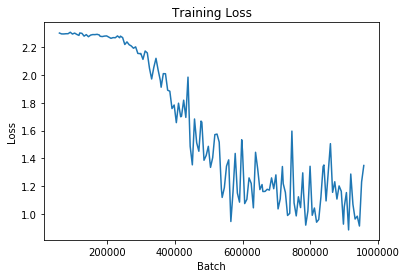

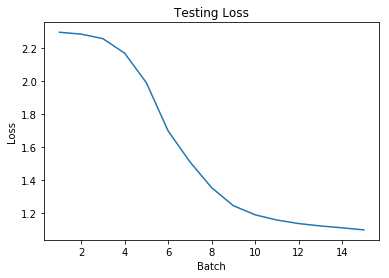

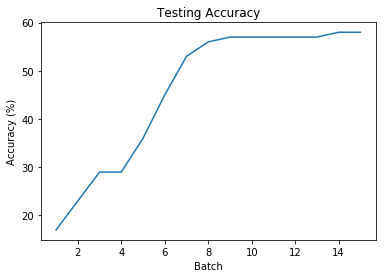

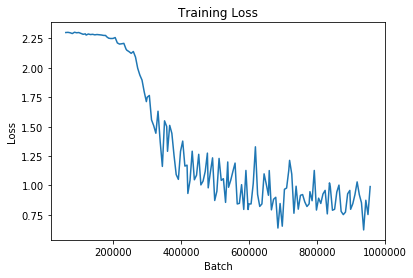

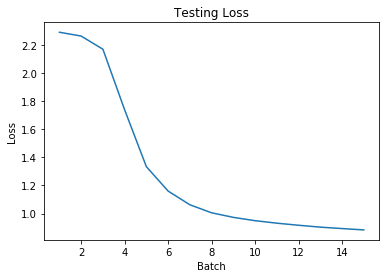

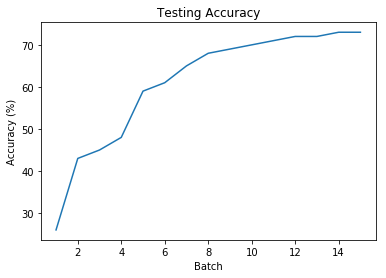

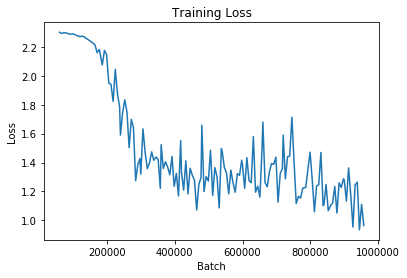

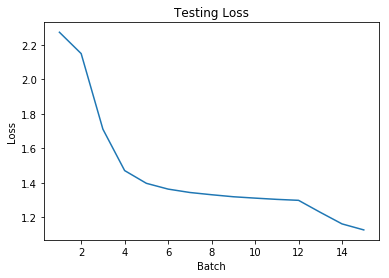

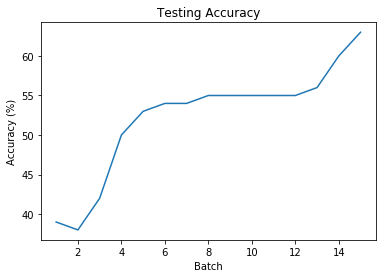

In [11]:
visualize_learning(NMLP_TRAINING_LOSS, NMLP_TEST_LOSS, NMLP_TEST_ACCURACY )
visualize_learning(CMLP_TRAINING_LOSS, CMLP_TEST_LOSS, CMLP_TEST_ACCURACY )
visualize_learning(WMLP_TRAINING_LOSS, WMLP_TEST_LOSS, WMLP_TEST_ACCURACY )

In [12]:
### train MLP
class NCMLP(nn.Module):
    '''
    3 Hidden Layers, Narrow Model Width for the Hidden Layers (total hidden neurons 2000)
    '''
    def __init__(self):
        super(NCMLP, self).__init__()
        self.fc1 = nn.Linear(784, 800)
        self.fc2 = nn.Linear(800, 600)
        self.fc3 = nn.Linear(600, 400)
        self.fc4 = nn.Linear(400, 200)
        self.fc5 = nn.Linear(200,10)
    def forward(self, x):
        x = x.view(-1, 784)
        x = F.relu(self.fc1(x)) 
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        x = F.relu(self.fc4(x))
        x = F.relu(self.fc5(x))
        return F.log_softmax(x, dim=1)

In [13]:
#train MLP
class CCMLP(nn.Module):
    '''
    3 Hidden Layers, Constant Model Width for the Hidden Layers (total hidden neurons 2000)
    '''
    def __init__(self):
        super(CCMLP, self).__init__()
        self.fc1 = nn.Linear(784, 500)
        self.fc2 = nn.Linear(500, 500)
        self.fc3 = nn.Linear(500, 500)
        self.fc4 = nn.Linear(500, 500)
        self.fc5 = nn.Linear(500,10)
    def forward(self, x):
        x = x.view(-1, 784)
        x = F.relu(self.fc1(x)) 
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        x = F.relu(self.fc4(x))
        x = F.relu(self.fc5(x))
        return F.log_softmax(x, dim=1)

In [14]:
#train MLP
class WCMLP(nn.Module):
    '''
    3 Hidden Layers, Wide Model Width for the Hidden Layers (total hidden neurons 2000)
    '''
    def __init__(self):
        super(WCMLP, self).__init__()
        self.fc1 = nn.Linear(784, 200)
        self.fc2 = nn.Linear(200, 400)
        self.fc3 = nn.Linear(400, 600)
        self.fc4 = nn.Linear(600, 800)
        self.fc5 = nn.Linear(800,10)
    def forward(self, x):
        x = x.view(-1, 784)
        x = F.relu(self.fc1(x)) 
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        x = F.relu(self.fc4(x))
        x = F.relu(self.fc5(x))
        return F.log_softmax(x, dim=1)

In [15]:
nc_mlp_model = NCMLP()
mlp_optimizer = optim.SGD(nc_mlp_model.parameters(), lr=LEARNING_RATE, momentum=SGD_MOMENTUM)
print(nc_mlp_model)
NCMLP_TRAINING_LOSS, NCMLP_TEST_LOSS, NCMLP_TEST_ACCURACY = learn(nc_mlp_model, mlp_optimizer, F.nll_loss)

NCMLP(
  (fc1): Linear(in_features=784, out_features=800, bias=True)
  (fc2): Linear(in_features=800, out_features=600, bias=True)
  (fc3): Linear(in_features=600, out_features=400, bias=True)
  (fc4): Linear(in_features=400, out_features=200, bias=True)
  (fc5): Linear(in_features=200, out_features=10, bias=True)
)
Train Epoch: 1 [0/60000 (0%)]	Loss: 2.303313


/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:45: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:46: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Train Epoch: 1 [6400/60000 (11%)]	Loss: 2.300680
Train Epoch: 1 [12800/60000 (21%)]	Loss: 2.296668
Train Epoch: 1 [19200/60000 (32%)]	Loss: 2.293984
Train Epoch: 1 [25600/60000 (43%)]	Loss: 2.300296
Train Epoch: 1 [32000/60000 (53%)]	Loss: 2.291920
Train Epoch: 1 [38400/60000 (64%)]	Loss: 2.285655
Train Epoch: 1 [44800/60000 (75%)]	Loss: 2.285790
Train Epoch: 1 [51200/60000 (85%)]	Loss: 2.280675
Train Epoch: 1 [57600/60000 (96%)]	Loss: 2.272317


/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:54: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:56: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number



Test set: Average loss: 2.2760, Accuracy: 4568/10000 (45%)

Train Epoch: 2 [0/60000 (0%)]	Loss: 2.281279
Train Epoch: 2 [6400/60000 (11%)]	Loss: 2.273586
Train Epoch: 2 [12800/60000 (21%)]	Loss: 2.278481
Train Epoch: 2 [19200/60000 (32%)]	Loss: 2.276744
Train Epoch: 2 [25600/60000 (43%)]	Loss: 2.253151
Train Epoch: 2 [32000/60000 (53%)]	Loss: 2.244032
Train Epoch: 2 [38400/60000 (64%)]	Loss: 2.247757
Train Epoch: 2 [44800/60000 (75%)]	Loss: 2.236875
Train Epoch: 2 [51200/60000 (85%)]	Loss: 2.228154
Train Epoch: 2 [57600/60000 (96%)]	Loss: 2.224064

Test set: Average loss: 2.1953, Accuracy: 5336/10000 (53%)

Train Epoch: 3 [0/60000 (0%)]	Loss: 2.191747
Train Epoch: 3 [6400/60000 (11%)]	Loss: 2.189020
Train Epoch: 3 [12800/60000 (21%)]	Loss: 2.130843
Train Epoch: 3 [19200/60000 (32%)]	Loss: 2.132756
Train Epoch: 3 [25600/60000 (43%)]	Loss: 2.122884
Train Epoch: 3 [32000/60000 (53%)]	Loss: 2.067219
Train Epoch: 3 [38400/60000 (64%)]	Loss: 1.985576
Train Epoch: 3 [44800/60000 (75%)]	Loss:

In [16]:
cc_mlp_model = CCMLP()
mlp_optimizer = optim.SGD(cc_mlp_model.parameters(), lr=LEARNING_RATE, momentum=SGD_MOMENTUM)
print(cc_mlp_model)
CCMLP_TRAINING_LOSS, CCMLP_TEST_LOSS, CCMLP_TEST_ACCURACY = learn(cc_mlp_model, mlp_optimizer, F.nll_loss)

CCMLP(
  (fc1): Linear(in_features=784, out_features=500, bias=True)
  (fc2): Linear(in_features=500, out_features=500, bias=True)
  (fc3): Linear(in_features=500, out_features=500, bias=True)
  (fc4): Linear(in_features=500, out_features=500, bias=True)
  (fc5): Linear(in_features=500, out_features=10, bias=True)
)
Train Epoch: 1 [0/60000 (0%)]	Loss: 2.303031


/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:45: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:46: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Train Epoch: 1 [6400/60000 (11%)]	Loss: 2.299070
Train Epoch: 1 [12800/60000 (21%)]	Loss: 2.299798
Train Epoch: 1 [19200/60000 (32%)]	Loss: 2.297984
Train Epoch: 1 [25600/60000 (43%)]	Loss: 2.291568
Train Epoch: 1 [32000/60000 (53%)]	Loss: 2.298200
Train Epoch: 1 [38400/60000 (64%)]	Loss: 2.297065
Train Epoch: 1 [44800/60000 (75%)]	Loss: 2.286504
Train Epoch: 1 [51200/60000 (85%)]	Loss: 2.286156
Train Epoch: 1 [57600/60000 (96%)]	Loss: 2.288467


/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:54: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:56: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number



Test set: Average loss: 2.2849, Accuracy: 3593/10000 (35%)

Train Epoch: 2 [0/60000 (0%)]	Loss: 2.283208
Train Epoch: 2 [6400/60000 (11%)]	Loss: 2.289601
Train Epoch: 2 [12800/60000 (21%)]	Loss: 2.271680
Train Epoch: 2 [19200/60000 (32%)]	Loss: 2.280311
Train Epoch: 2 [25600/60000 (43%)]	Loss: 2.288897
Train Epoch: 2 [32000/60000 (53%)]	Loss: 2.266288
Train Epoch: 2 [38400/60000 (64%)]	Loss: 2.263938
Train Epoch: 2 [44800/60000 (75%)]	Loss: 2.250098
Train Epoch: 2 [51200/60000 (85%)]	Loss: 2.264243
Train Epoch: 2 [57600/60000 (96%)]	Loss: 2.263175

Test set: Average loss: 2.2488, Accuracy: 4107/10000 (41%)

Train Epoch: 3 [0/60000 (0%)]	Loss: 2.253385
Train Epoch: 3 [6400/60000 (11%)]	Loss: 2.253423
Train Epoch: 3 [12800/60000 (21%)]	Loss: 2.238527
Train Epoch: 3 [19200/60000 (32%)]	Loss: 2.230233
Train Epoch: 3 [25600/60000 (43%)]	Loss: 2.229368
Train Epoch: 3 [32000/60000 (53%)]	Loss: 2.221049
Train Epoch: 3 [38400/60000 (64%)]	Loss: 2.223595
Train Epoch: 3 [44800/60000 (75%)]	Loss:

In [17]:
wc_mlp_model = WCMLP()
mlp_optimizer = optim.SGD(wc_mlp_model.parameters(), lr=LEARNING_RATE, momentum=SGD_MOMENTUM)
print(wc_mlp_model)
WCMLP_TRAINING_LOSS, WCMLP_TEST_LOSS, WCMLP_TEST_ACCURACY = learn(wc_mlp_model, mlp_optimizer, F.nll_loss)

WCMLP(
  (fc1): Linear(in_features=784, out_features=200, bias=True)
  (fc2): Linear(in_features=200, out_features=400, bias=True)
  (fc3): Linear(in_features=400, out_features=600, bias=True)
  (fc4): Linear(in_features=600, out_features=800, bias=True)
  (fc5): Linear(in_features=800, out_features=10, bias=True)
)
Train Epoch: 1 [0/60000 (0%)]	Loss: 2.301798


/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:45: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:46: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Train Epoch: 1 [6400/60000 (11%)]	Loss: 2.295731
Train Epoch: 1 [12800/60000 (21%)]	Loss: 2.301388
Train Epoch: 1 [19200/60000 (32%)]	Loss: 2.295969
Train Epoch: 1 [25600/60000 (43%)]	Loss: 2.293679
Train Epoch: 1 [32000/60000 (53%)]	Loss: 2.294461
Train Epoch: 1 [38400/60000 (64%)]	Loss: 2.302417
Train Epoch: 1 [44800/60000 (75%)]	Loss: 2.299467
Train Epoch: 1 [51200/60000 (85%)]	Loss: 2.293669
Train Epoch: 1 [57600/60000 (96%)]	Loss: 2.297974


/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:54: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:56: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number



Test set: Average loss: 2.2928, Accuracy: 2172/10000 (21%)

Train Epoch: 2 [0/60000 (0%)]	Loss: 2.297522
Train Epoch: 2 [6400/60000 (11%)]	Loss: 2.283787
Train Epoch: 2 [12800/60000 (21%)]	Loss: 2.289577
Train Epoch: 2 [19200/60000 (32%)]	Loss: 2.288715
Train Epoch: 2 [25600/60000 (43%)]	Loss: 2.282766
Train Epoch: 2 [32000/60000 (53%)]	Loss: 2.279455
Train Epoch: 2 [38400/60000 (64%)]	Loss: 2.290249
Train Epoch: 2 [44800/60000 (75%)]	Loss: 2.285594
Train Epoch: 2 [51200/60000 (85%)]	Loss: 2.277475
Train Epoch: 2 [57600/60000 (96%)]	Loss: 2.262427

Test set: Average loss: 2.2690, Accuracy: 3150/10000 (31%)

Train Epoch: 3 [0/60000 (0%)]	Loss: 2.282229
Train Epoch: 3 [6400/60000 (11%)]	Loss: 2.238936
Train Epoch: 3 [12800/60000 (21%)]	Loss: 2.251415
Train Epoch: 3 [19200/60000 (32%)]	Loss: 2.273620
Train Epoch: 3 [25600/60000 (43%)]	Loss: 2.252977
Train Epoch: 3 [32000/60000 (53%)]	Loss: 2.223874
Train Epoch: 3 [38400/60000 (64%)]	Loss: 2.176697
Train Epoch: 3 [44800/60000 (75%)]	Loss:

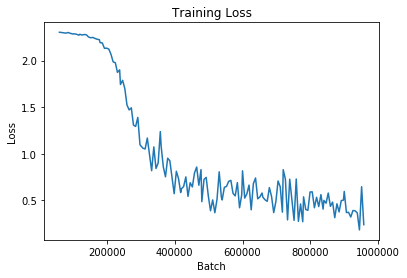

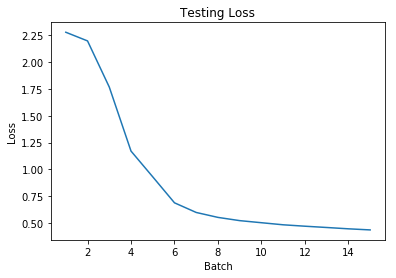

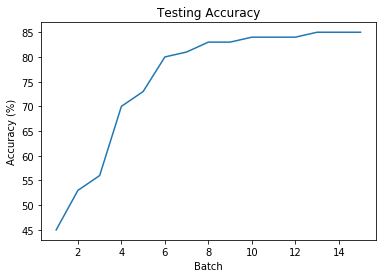

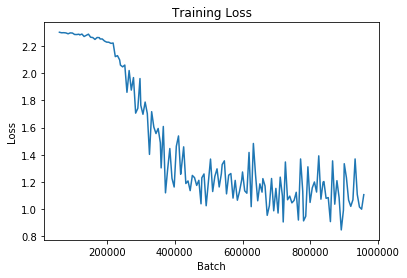

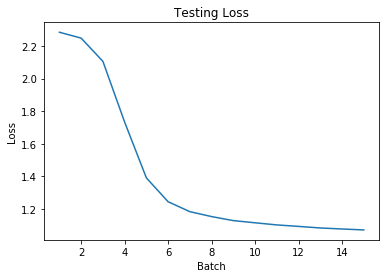

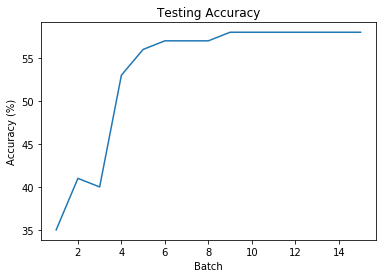

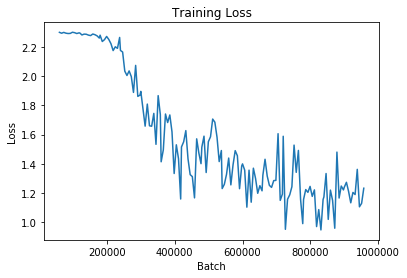

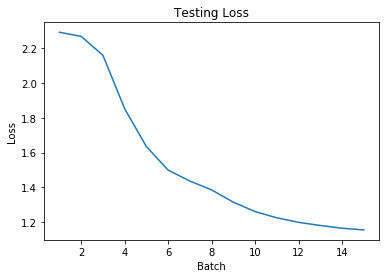

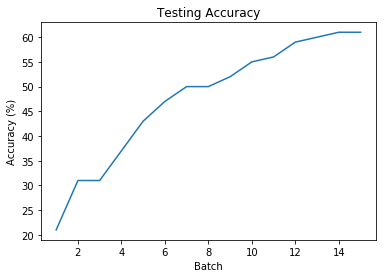

In [18]:
visualize_learning(NCMLP_TRAINING_LOSS, NCMLP_TEST_LOSS, NCMLP_TEST_ACCURACY )
visualize_learning(CCMLP_TRAINING_LOSS, CCMLP_TEST_LOSS, CCMLP_TEST_ACCURACY )
visualize_learning(WCMLP_TRAINING_LOSS, WCMLP_TEST_LOSS, WCMLP_TEST_ACCURACY )

In [110]:
#map connections
def convert_sd_to_adj(name, state_dict):
    keys = state_dict.keys()
    weights = []
    biases = []
    for k in keys:
        if "weight" in k:
            weights.append(k)
        elif "bias" in k:
            biases.append(k)
    
    edges = []
    in_dim_start = 0
    for w in weights:
        edge_weights = state_dict[w].numpy()
        edge_weights = edge_weights.T
        for i in range(edge_weights.shape[0]):
            in_dim = in_dim_start + i
            for j in range(edge_weights.shape[1]):
                out_dim = in_dim_start + edge_weights.shape[0] + j
                edges.append((in_dim, out_dim, edge_weights[i][j]))
        in_dim_start = in_dim_start + edge_weights.shape[0]
                
    open(name + '.adj', 'w').write('\n'.join('%s %s %s' % x for x in edges))

In [111]:
#assign weights
convert_sd_to_adj("narrow_mlp", narrow_mlp_model.state_dict())
convert_sd_to_adj("constant_mlp", constant_mlp_model.state_dict())
convert_sd_to_adj("wider_mlp", wider_mlp_model.state_dict())
convert_sd_to_adj("nc_mlp", nc_mlp_model.state_dict())
convert_sd_to_adj("cc_mlp", cc_mlp_model.state_dict())
convert_sd_to_adj("wc_mlp", wc_mlp_model.state_dict())

In [7]:
#load into networkx
#train MLP
class SIMPLEMLP(nn.Module):
    '''
    1 Hidden Layers, Wide Model Width for the Hidden Layers (total hidden neurons 2000)
    '''
    def __init__(self):
        super(SIMPLEMLP, self).__init__()
        self.fc1 = nn.Linear(784, 400)
        self.fc2 = nn.Linear(400,400)
        self.fc3 = nn.Linear(400,10)
    def forward(self, x):
        x = x.view(-1, 784)
        x = F.relu(self.fc1(x)) 
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        return F.log_softmax(x, dim=1)

In [9]:
#run analysis
EPOCHS = 15                #@param {type:"integer"}           #Number of times to go through the data set
SGD_MOMENTUM = 0.5        #@param {type:"number"}            #How much it takes to change the direction of the gradient
LEARNING_RATE = 0.001     #@param {type:"number"}            #How far each update pushes the weights
small_mlp_model = SIMPLEMLP()
smlp_optimizer = optim.SGD(small_mlp_model.parameters(), lr=LEARNING_RATE, momentum=SGD_MOMENTUM)
print(small_mlp_model)
SMLP_TRAINING_LOSS, SMLP_TEST_LOSS, SMLP_TEST_ACCURACY = learn(small_mlp_model,smlp_optimizer, F.nll_loss)

SIMPLEMLP(
  (fc1): Linear(in_features=784, out_features=400, bias=True)
  (fc2): Linear(in_features=400, out_features=400, bias=True)
  (fc3): Linear(in_features=400, out_features=10, bias=True)
)
Train Epoch: 1 [0/60000 (0%)]	Loss: 2.304749


/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:45: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:46: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Train Epoch: 1 [6400/60000 (11%)]	Loss: 2.280663
Train Epoch: 1 [12800/60000 (21%)]	Loss: 2.245821
Train Epoch: 1 [19200/60000 (32%)]	Loss: 2.223229
Train Epoch: 1 [25600/60000 (43%)]	Loss: 2.191729
Train Epoch: 1 [32000/60000 (53%)]	Loss: 2.167569
Train Epoch: 1 [38400/60000 (64%)]	Loss: 2.038843
Train Epoch: 1 [44800/60000 (75%)]	Loss: 1.938009
Train Epoch: 1 [51200/60000 (85%)]	Loss: 1.865057
Train Epoch: 1 [57600/60000 (96%)]	Loss: 1.854351


/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:54: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:56: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number



Test set: Average loss: 1.8204, Accuracy: 4572/10000 (45%)

Train Epoch: 2 [0/60000 (0%)]	Loss: 1.930724
Train Epoch: 2 [6400/60000 (11%)]	Loss: 1.635607
Train Epoch: 2 [12800/60000 (21%)]	Loss: 1.726221
Train Epoch: 2 [19200/60000 (32%)]	Loss: 1.881811
Train Epoch: 2 [25600/60000 (43%)]	Loss: 1.571347
Train Epoch: 2 [32000/60000 (53%)]	Loss: 1.561795
Train Epoch: 2 [38400/60000 (64%)]	Loss: 1.565115
Train Epoch: 2 [44800/60000 (75%)]	Loss: 1.568568
Train Epoch: 2 [51200/60000 (85%)]	Loss: 1.553263
Train Epoch: 2 [57600/60000 (96%)]	Loss: 1.241269

Test set: Average loss: 1.4234, Accuracy: 5374/10000 (53%)

Train Epoch: 3 [0/60000 (0%)]	Loss: 1.336681
Train Epoch: 3 [6400/60000 (11%)]	Loss: 1.545114
Train Epoch: 3 [12800/60000 (21%)]	Loss: 1.528639
Train Epoch: 3 [19200/60000 (32%)]	Loss: 1.357174
Train Epoch: 3 [25600/60000 (43%)]	Loss: 1.358441
Train Epoch: 3 [32000/60000 (53%)]	Loss: 1.240529
Train Epoch: 3 [38400/60000 (64%)]	Loss: 1.394449
Train Epoch: 3 [44800/60000 (75%)]	Loss:

In [10]:
convert_sd_to_adj("simple_mlp", small_mlp_model.state_dict())

NameError: name 'convert_sd_to_adj' is not defined